<a href="https://colab.research.google.com/github/zoe-zhang99/gender-pay-gap-visualization-kaggle-survey/blob/main/spotify-song-popularity-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is written by Zoe Zhang, Chen Yang & Jinmeng Liu for CIS 545 final project

# **Task Explained**

In this project, we are using spotify music datasets from Kaggle (https://www.kaggle.com/code/vatsalmavani/music-recommendation-system-using-spotify-dataset/notebook) to look at the music features of songs and predict song popularity based on the features.

Originally, we used Spotify API to scrape the weekly top 200 songs in the United States and using Spotify music analysis to analyze the music. However, the API is later blocked and the data is not enough for the project, so we decided to work on this dataset instead.

The project is mainly divided into two parts.

1. EDA
- Music and Artists over the years
- Music feature changes
- Artist of the ten years
- Correlation between features and popularity

2. Model Training
- Regression
- Multi-class classification
- Binary classification

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import copy
import warnings
warnings.filterwarnings("ignore")
plotly.offline.init_notebook_mode (connected = True)

%matplotlib inline

In [ ]:
!pip install squarify
import squarify as sq

read file from local file

In [ ]:
df = pd.read_csv('data.csv')

read from google drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')
#%cd /content/drive/My Drive/Colab Notebooks/
#df = pd.read_csv('/content/drive/MyDrive/cis545 - spotify/data.csv')

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


In [ ]:
df.shape

(170653, 19)

In [ ]:
# check missing values
df.isnull().sum()

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

# **Dataset Description**

## Songs and artists in the dataset

In [ ]:
pd.set_option('precision', 2)
df.describe()

valence      year  acousticness    artists  danceability  \
count  170653.00  170653.0     170653.00  170653.00     170653.00   
mean        0.53    1970.0          0.50   17242.83          0.54   
std         0.26       0.0          0.38    9882.44          0.18   
min         0.00    1970.0          0.00       0.00          0.00   
25%         0.32    1970.0          0.10    8842.00          0.41   
50%         0.54    1970.0          0.52   17089.00          0.55   
75%         0.75    1970.0          0.89   26036.00          0.67   
max         1.00    1970.0          1.00   34086.00          0.99   

       duration_ms     energy   explicit  instrumentalness        key  \
count     1.71e+05  170653.00  170653.00          1.71e+05  170653.00   
mean      2.31e+05       0.48       0.08          1.67e-01       5.20   
std       1.26e+05       0.27       0.28          3.13e-01       3.52   
min       5.11e+03       0.00       0.00          0.00e+00       0.00   
25%       1.70e+05       0.26       0.00          0.00e+00       2.00   
50%       2.07e+05       0.47       0.00          2.16e-04       5.00   
75%       2.62e+05       0.70       0.00          1.02e-01       8.00   
max       5.40e+06       1.00       1.00          1.00e+00      11.00   

        liveness   loudness       mode  popularity  speechiness      tempo  
count  170653.00  170653.00  170653.00   170653.00    170653.00  170653.00  
mean        0.21     -11.47       0.71       31.43         0.10     116.86  
std         0.17       5.70       0.46       21.83         0.16      30.71  
min         0.00     -60.00       0.00        0.00         0.00       0.00  
25%         0.10     -14.62       0.00       11.00         0.03      93.42  
50%         0.14     -10.58       1.00       33.00         0.04     114.73  
75%         0.26      -7.18       1.00       48.00         0.08     135.54  
max         1.00       3.85       1.00      100.00         0.97     243.51

What is the song distribution? Let's take a look at the song counts from 1921 to 2020

In [ ]:
year_groupby = df.groupby('year')['id'].agg(len).to_frame().reset_index()
fig = go.Figure(data=go.Scatter(x=year_groupby['year'].astype(dtype=str), 
                        y=year_groupby['id'],
                        marker_color='indianred', text="counts"))
fig.update_layout({"title": 'Song counts from 1921 to 2020',
                   "xaxis": {"title":"Year"},
                   "yaxis": {"title":"Count"},
                   "showlegend": False})
fig.show(renderer = 'colab')

First, we want to take a look at who are the singers with the most songs all over the 100 years. How many singers are you familiar with?

I only know Elvis, Bob Dylan, Queen and The Beatles.

In [ ]:
df['artists'] = df['artists'].str.replace("[","")
df['artists'] = df['artists'].str.replace("'","")
df['artists'] = df['artists'].str.replace("]","")

artist_groupby = df.groupby('artists')['id'].agg(len).sort_values(ascending = False).to_frame().reset_index().head(20)
fig = go.Figure(data=go.Bar(x=artist_groupby['artists'].astype(dtype=str), 
                        y=artist_groupby['id'],
                        marker_color='indianred'))
fig.update_layout({"title": 'Artist Name vs Count of songs',
                   "xaxis": {"title":"Artists"},
                   "yaxis": {"title":"Count"},
                   "showlegend": False})
fig.show(renderer = 'colab')

But we might be more interested in seeing what are the most popular songs. 

No Taylor Swift or Adele in top 20, what a surprise.

In [ ]:
pop_songs = df.sort_values(by = 'popularity', ascending = False)[['popularity', 'artists']].head(20)
fig = go.Figure(data=go.Bar(x=pop_songs['artists'].astype(dtype=str), 
                        y=pop_songs['popularity'],
                        marker_color='indianred'))
fig.update_layout({"title": 'Most Popular Songs by Artists',
                   "xaxis": {"title":"Artists"},
                   "yaxis": {"title":"Popularity"},
                   "showlegend": False})
fig.show(renderer = 'colab')

## Music Features Overview

Next, we would like to explore the relationship between danceability, valence and energy

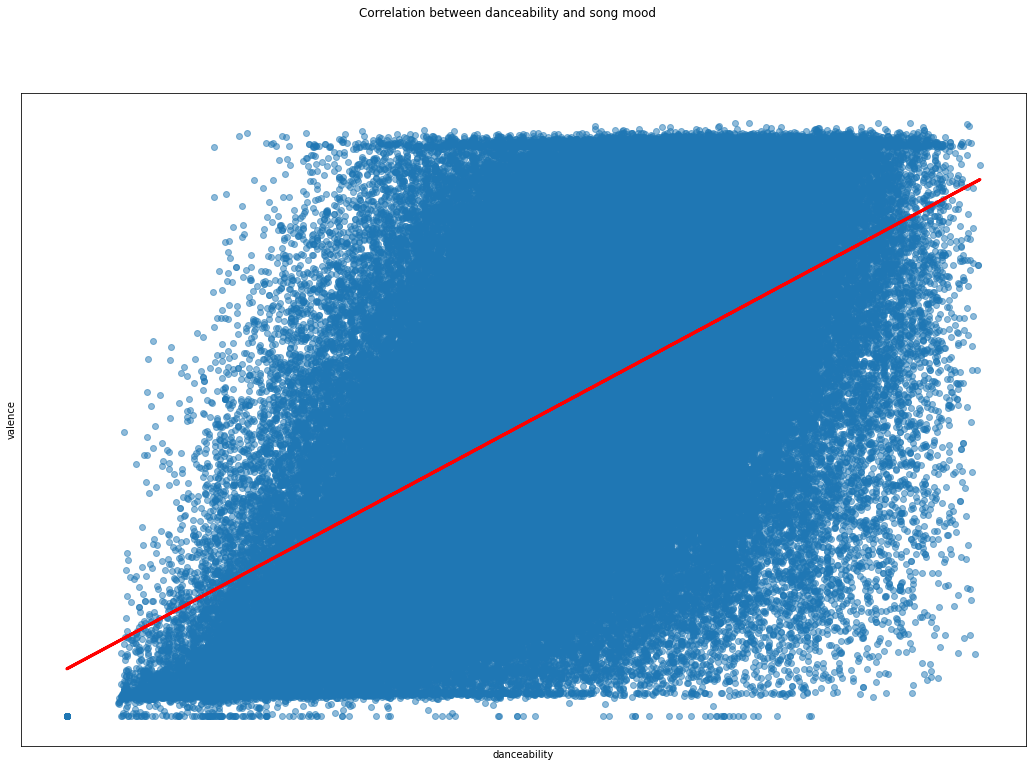

In [ ]:
x = df["danceability"].values
y = df["valence"].values

x = x.reshape(x.shape[0], 1)
y = y.reshape(y.shape[0], 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

fig = plt.figure(figsize=(18, 12))
fig.suptitle("Correlation between danceability and song mood")

ax = plt.subplot(1, 1, 1)
ax.scatter(x, y, alpha=0.5)
ax.plot(x, regr.predict(x), color="red", linewidth=3)
plt.xticks(())
plt.yticks(())

plt.xlabel("danceability")
plt.ylabel("valence")

plt.show()

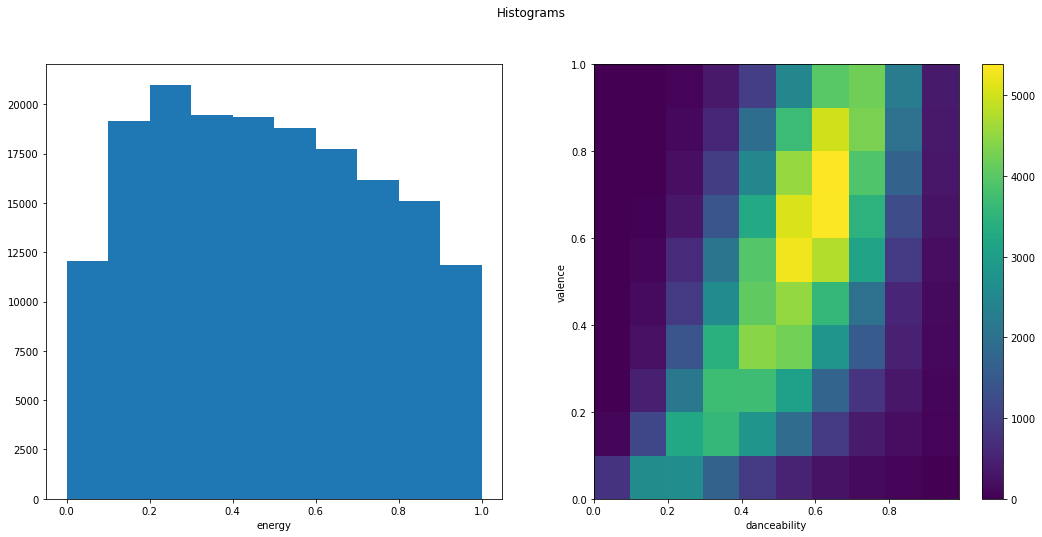

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(18, 8))
fig.suptitle("Histograms")
h = ax2.hist2d(df.danceability, df.valence)
ax1.hist(df.energy)

ax2.set_xlabel("danceability")
ax2.set_ylabel("valence")

ax1.set_xlabel("energy")

plt.colorbar(h[3], ax=ax2)

plt.show()

It looks like both valence and energy are positively correlated with danceability

Correlation Map
(drop year as it is not correlated with any other musical features)

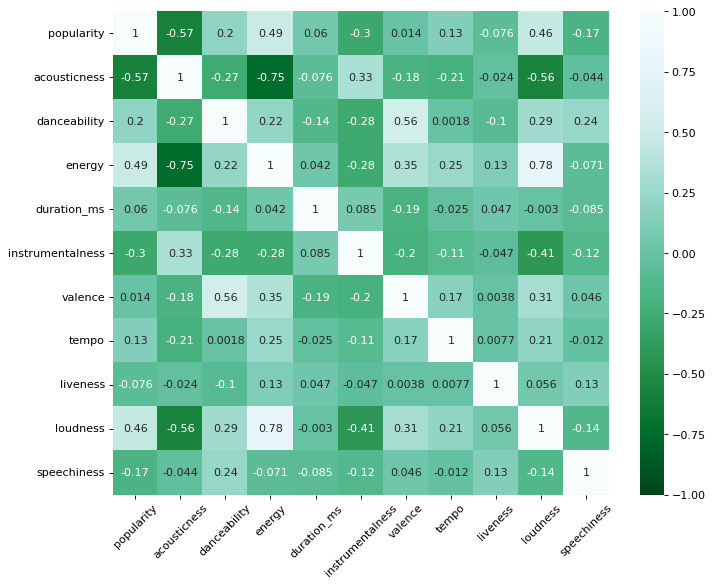

In [ ]:
track_attributes = ["popularity","acousticness",
                    "danceability", 
                    "energy", 
                    "duration_ms", 
                    "instrumentalness", 
                    "valence", 
                    "tempo", 
                    "liveness", 
                    "loudness", 
                    "speechiness"]

plt.figure(figsize = (10,8), dpi = 80)
sns.heatmap(df[track_attributes].corr(),vmin=-1, vmax=1, annot=True, cmap = 'BuGn_r' )
plt.xticks(rotation = 45)
plt.show()

Now let's take a closer look to the variables with the strongest correlation to popularity

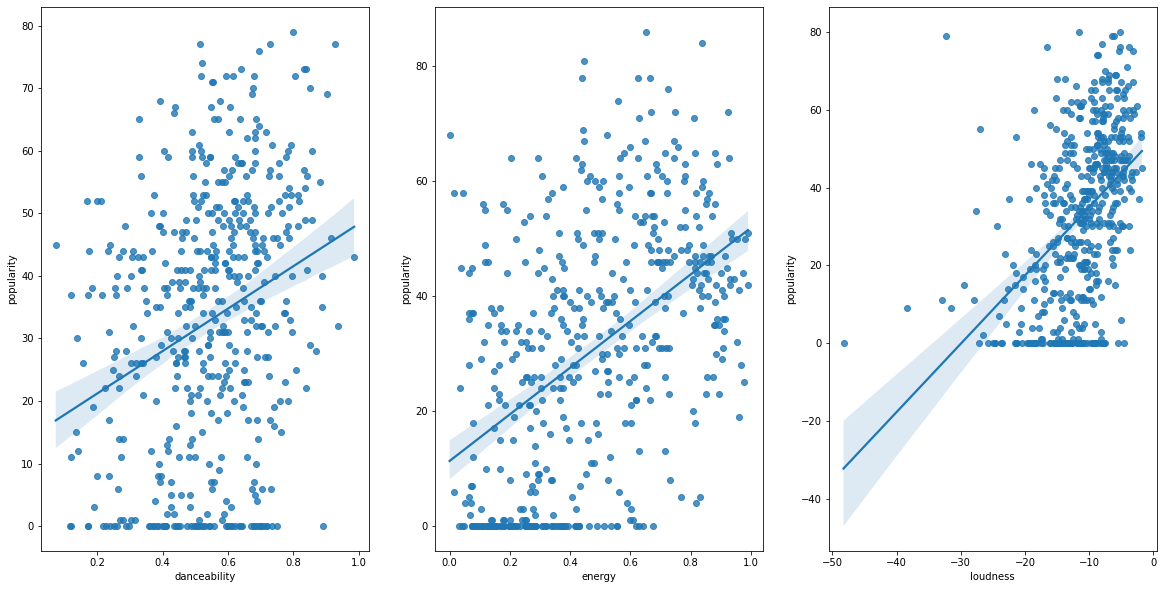

In [ ]:
corr_vars = ['danceability', 'energy', 'loudness']

plt.figure(figsize = (20, 10))

for i in enumerate(corr_vars):
    plt.subplot(1,3,i[0]+1)
    sns.regplot(data = df.sample(500), y = 'popularity', x = i[1])
plt.show()

How Popularity is correlated to danceability

In [ ]:
fig= px.scatter(df_decades_trend, x="popularity",y="danceability", color="danceability",size='popularity')
fig.show(renderer="colab")

It appears that the songs with high danceability is more popular.

How Popularity is correlated to instrumentalness

In [ ]:
fig = px.scatter(df_decades_trend, x="popularity",y="instrumentalness", color="instrumentalness",size='popularity')
fig.show(renderer="colab")

It can be seen that high instrumentalness does not bring high popularity but the contary.

Text(0.5, 0, 'Year')

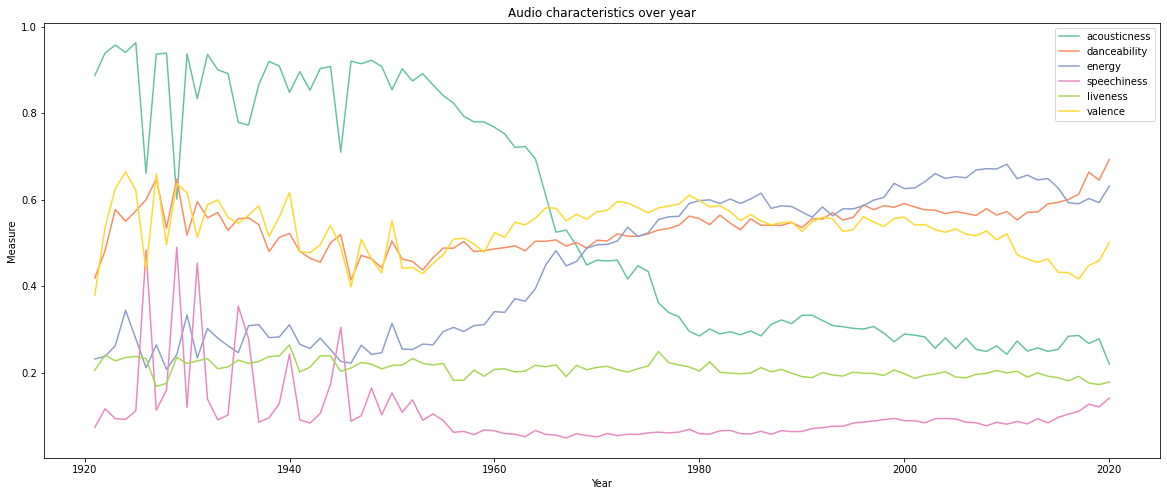

In [ ]:
audio_attributes = ["acousticness","danceability","energy","speechiness","liveness","valence"]

plt.figure(figsize = (20, 8))
sns.set_palette('Set2')
for attribute in audio_attributes:
    x = df.groupby("year")[attribute].mean()
    sns.lineplot(x=x.index,y=x,label=attribute)

    
    plt.title('Audio characteristics over year')
plt.ylabel('Measure')
plt.xlabel('Year')

Let's take a look at the features of popular songs

In [ ]:
popular_songs = df[df['popularity'] >= 80]
popular_songs_attributes = ["acousticness",
                    "danceability", 
                    "energy", 
                    "duration_ms", 
                    "instrumentalness", 
                    "valence", 
                    "tempo", 
                    "liveness", 
                    "loudness", 
                    "speechiness"]

popular_songs[popular_songs_attributes].mean()

acousticness             0.239699
danceability             0.675593
energy                   0.621782
duration_ms         204399.728198
instrumentalness         0.013075
valence                  0.502527
tempo                  121.389202
liveness                 0.162580
loudness                -6.444103
speechiness              0.105004
dtype: float64

Looks like not so popular songs is more heavy on acousticness, but less on danceability

In [ ]:
not_popular_songs = df[df['popularity'] <=10]
not_popular_songs_attributes = ["acousticness",
                    "danceability", 
                    "energy", 
                    "duration_ms", 
                    "instrumentalness", 
                    "valence", 
                    "tempo", 
                    "liveness", 
                    "loudness", 
                    "speechiness"]

not_popular_songs[not_popular_songs_attributes].mean()

acousticness             0.845349
danceability             0.501948
energy                   0.277592
duration_ms         213735.292770
instrumentalness         0.324920
valence                  0.504878
tempo                  109.809226
liveness                 0.220638
loudness               -15.017333
speechiness              0.167179
dtype: float64

## Comparison between popular songs and non-popular songs

In [ ]:
labels = [ "valence", "danceability", "energy", "acousticness","instrumentalness", "liveness","speechiness"]

avg_pop  = popular_songs[labels].mean().reset_index()
avg_non_pop  = not_popular_songs[labels].mean().reset_index()

avg_pop = pd.DataFrame(avg_pop)
avg_pop = avg_pop.rename(columns={avg_pop.columns[0]: 'features'})
avg_pop =avg_pop.rename(columns={avg_pop.columns[1]: 'score'})
avg_pop['pop'] = 1

avgavg_non_pop_pop = pd.DataFrame(avg_non_pop)
avg_non_pop = avg_non_pop.rename(columns={avg_non_pop.columns[0]: 'features'})
avg_non_pop =avg_non_pop.rename(columns={avg_non_pop.columns[1]: 'score'})
avg_non_pop['pop'] = 0

comp = pd.concat([avg_pop, avg_non_pop])

In [ ]:
fig = px.line_polar(comp, theta = "features", r = "score", color="pop", line_close=True,
                    color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)
fig.update_layout(
    title="Audio Feature Comparison by Popularity (Popular song = 1)",
)

fig.show(renderer = 'colab')

So, popular songs are more heavy on danceability and energy, but less on acousticness and instrumentalness.

## Ten years' trend

Using the data grouped by year, we can understand how the overall genre of music has changed during each decade from 1921 to 2020.

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly

def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

df['decade'] = df['year'].apply(get_decade)

sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
df_decades_trend=df.groupby("decade") ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence','popularity'].mean()

fig = px.line(df_decades_trend.iloc[:,:-1])

fig.show(renderer="colab")

## Artists of Ten Years

It is interesting to know who are the icon artists of each decade from 1920s to 2020s. So we presented 10 wordcloud plots.


In [ ]:
from wordcloud import WordCloud

def create_wordcloud(i):
    namelist = []
    for element in df[df['decade']==i]['artists']:
        namelist.append(element)

    new = []
    for ele in namelist:
        k = list(ele.split("'"))
        new.append(k)

    artists_lst = []
    for element in new:
        for ele in element:
            if ele != '[' and ele != ']' and ele != ', ':
                artists_lst.append(ele)


    artist_text = ' '.join(artists_lst)


    # print("Wordcloud of ",i)

    top_wc=WordCloud(width=800,height=800,
                    background_color="white",
                    min_font_size=10).generate(artist_text)

    plt.figure(figsize=(8,8))
    # print("Wordcloud of ",i)
    plt.imshow(top_wc)
    plt.axis("off")


-----------------------Artists of 1920s-----------------------------------




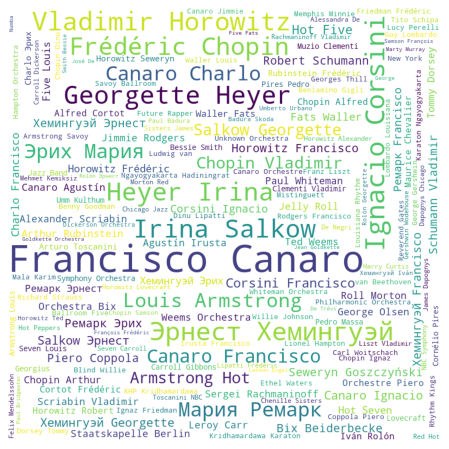

In [ ]:
print ("\n-----------------------Artists of 1920s-----------------------------------\n\n")
create_wordcloud("1920s")


-----------------------Artists of 1930s-----------------------------------




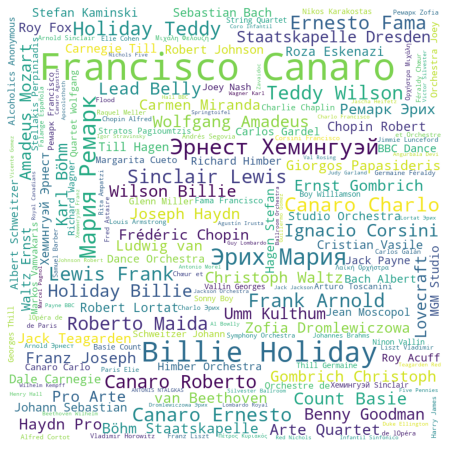

In [ ]:
print ("\n-----------------------Artists of 1930s-----------------------------------\n\n")
create_wordcloud("1930s")


-----------------------Artists of 1940s-----------------------------------




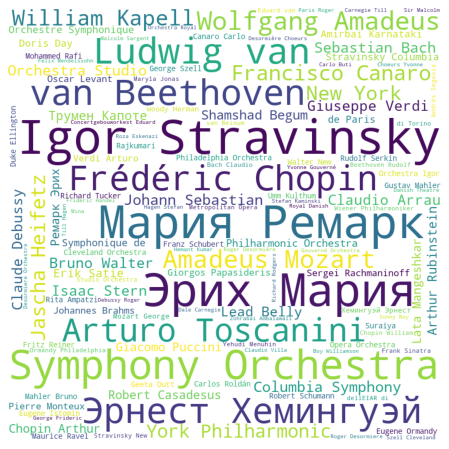

In [ ]:
print ("\n-----------------------Artists of 1940s-----------------------------------\n\n")
create_wordcloud("1940s")


-----------------------Artists of 1950s-----------------------------------




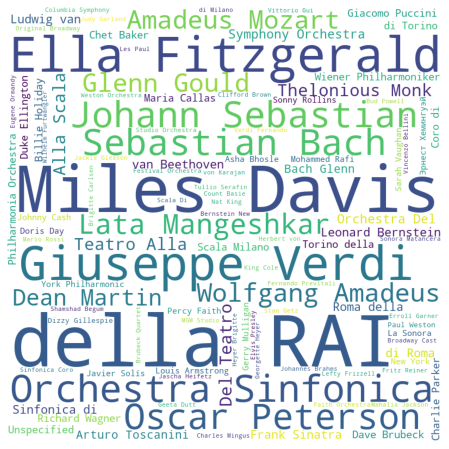

In [ ]:
print ("\n-----------------------Artists of 1950s-----------------------------------\n\n")
create_wordcloud("1950s")


-----------------------Artists of 1960s-----------------------------------




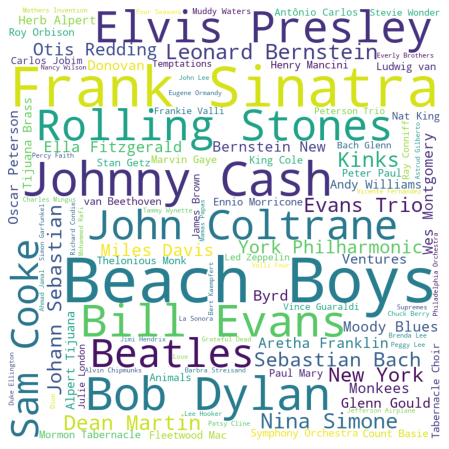

In [ ]:
print ("\n-----------------------Artists of 1960s-----------------------------------\n\n")
create_wordcloud("1960s")


-----------------------Artists of 1970s-----------------------------------




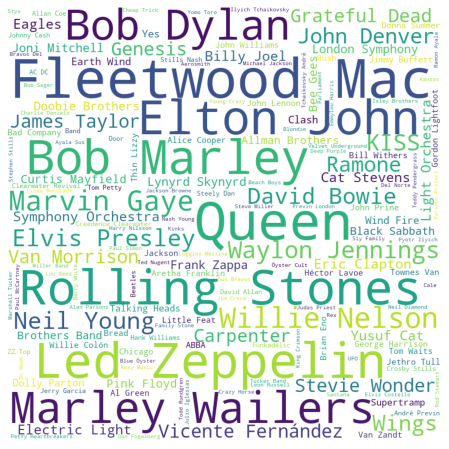

In [ ]:
print ("\n-----------------------Artists of 1970s-----------------------------------\n\n")
create_wordcloud("1970s")


-----------------------Artists of 1980s-----------------------------------




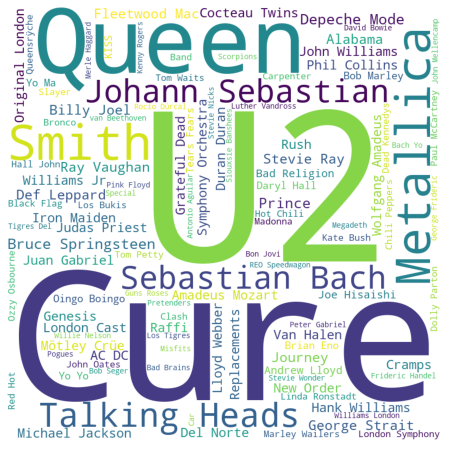

In [ ]:
print ("\n-----------------------Artists of 1980s-----------------------------------\n\n")
create_wordcloud("1980s")


-----------------------Artists of 1990s-----------------------------------




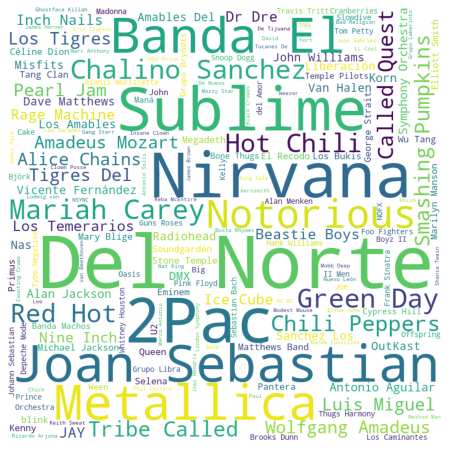

In [ ]:
print ("\n-----------------------Artists of 1990s-----------------------------------\n\n")
create_wordcloud("1990s")


-----------------------Artists of 2000s-----------------------------------




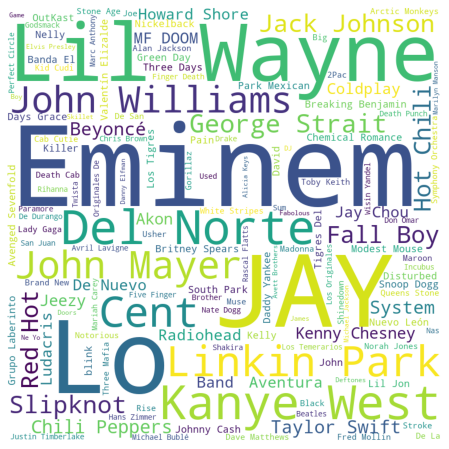

In [ ]:
print ("\n-----------------------Artists of 2000s-----------------------------------\n\n")
create_wordcloud("2000s")


-----------------------Artists of 2010s-----------------------------------




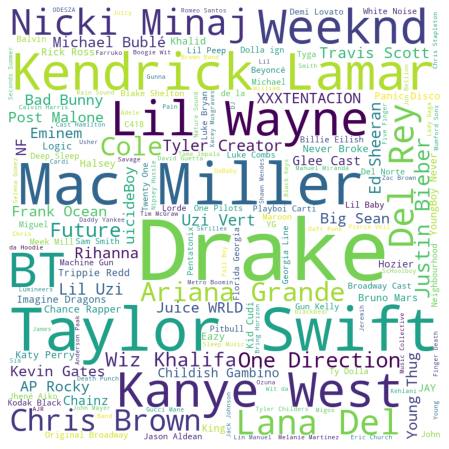

In [ ]:
print ("\n-----------------------Artists of 2010s-----------------------------------\n\n")
create_wordcloud("2010s")


-----------------------Artists of 2020-----------------------------------



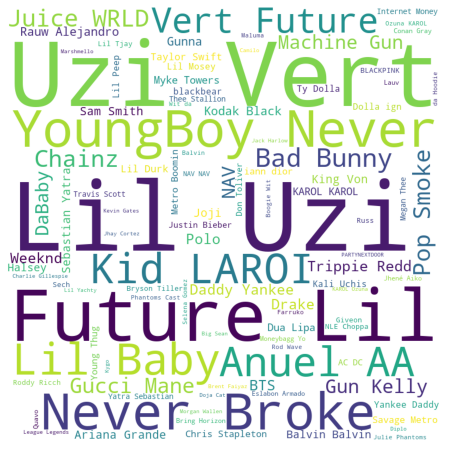

In [ ]:
print ("\n-----------------------Artists of 2020-----------------------------------\n")
create_wordcloud("2020s")

# **Predict Popularity**

Now we know the features of the music, we wonder if we can predict the song popularity using those features and inform the artists what might be the styles they would like to consider to be popular when making music.

Also, it might be useful for the music companies to evaluate or predict song popularity they produce.

In [ ]:
# the distribution of our dependent variable
fig = px.histogram(pd.DataFrame(y), x=pd.DataFrame(y).columns, 
                   title="Distribution of Popularity Score")
fig.update_layout(bargap=0.2)
fig.show(renderer="colab")

## Variable Overview

In [ ]:
X = df.drop(["id","name", "popularity","release_date"], axis = 1)

In [ ]:
X.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo'],
      dtype='object')

* Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* Year: The year that the song was released.
* Acousticness: This value describes how acoustic a song is. A score of 1.0 means the song is most likely to be an acoustic one.
* artists: The artist name(s) of the song.
* danceability: This describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* duration_ms: The duration of the song in ms.         
* energy: represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
* explicit: An explicit track is one that has curse words or language or art that is sexual, violent, or offensive in nature.
* id: link of the song.
* instrumentalness: This value represents the amount of vocals in the song. The closer it is to 1.0, the more instrumental the song is.
* key: this is the main group of pitches, or notes, that form the harmonic foundation of a piece of music.
* liveness: This value describes the probability that the song was recorded with a live audience. A value above 0.8 provides strong likelihood that the track is live.
* loudness: Attribute of auditory sensation in terms of which sounds can be ordered on a scale extending from quiet to loud.
* mode: A type of musical scale coupled with a set of characteristic melodic and harmonic behaviors. 
* name: track name of the song.
* popularity: This measures how popularity a song is, and this value is an integer between 0 and 100.
* speechiness: detects the presence of spoken words in a track. If the speechiness of a song is above 0.66, it is probably made of spoken words, a score between 0.33 and 0.66 is a song that may contain both music and words, and a score below 0.33 means the song does not have any speech.
* tempo: this is how fast the beats go by in a particular piece of music, which is measured according to beats per minute (bpm).   

# **Part 1: Regression**

In this part, we are using three regression models: linear regression, random forest regression, and lasso regression. 

The evaluation metrics  we choose are MSE, MAE, and R squared.
* Mean Squared Error
    Mean Squared Error, or MSE for short, is a popular error metric for regression problems.

    It is also an important loss function for algorithms fit or optimized using the least squares framing of a regression problem. Here “least squares” refers to minimizing the mean squared error between predictions and expected values.

* Mean of the absolute difference between the actual value in the dataset and the value predicted by the model.

    The absolute values are taken, and if it’s not then the negative and positive difference will cancel out each other. The smaller the MAE, the more accurate the model is. If MAE is zero it shows the model is perfect. If MAE is large then the model is not good.



* R-squared or Coefficient of Determination

    This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.



### Data Preprocessing

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import r2_score,mean_absolute_error

from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

In [ ]:
#transform artist into numerical feature
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df["artists"]=encoder.fit_transform(df["artists"])

df[["year","release_date"]] = df[["year","release_date"]].apply(pd.to_datetime)
df['year'] = pd.DatetimeIndex(df['year']).year
df['release_date'] = pd.DatetimeIndex(df['release_date']).year

from sklearn.model_selection import train_test_split
X = df.drop(["id","name", "popularity","release_date","decade"], axis = 1)
y = df["popularity"]

### Test, Train Split & Scale Standardization

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear regression

#### Linear Regression Model using original features

In [ ]:
from sklearn.utils.extmath import squared_norm

linear_reg=LinearRegression()
linear_reg.fit(x_train, y_train)

y_pred=linear_reg.predict(x_test)

print ("intercept:",linear_reg.intercept_)
print ("coefficients:",linear_reg.coef_)

MSE=[]
MAE=[]
R_Squared=[]

MSE.append(metrics.mean_squared_error(y_test, y_pred))
MAE.append(metrics.mean_absolute_error(y_test, y_pred))
R_Squared.append(r2_score(y_test, y_pred))

print("MSE: ",metrics.mean_squared_error(y_test, y_pred))
print("MAE:",metrics.mean_absolute_error(y_test, y_pred))
print("R-Squared:",r2_score(y_test, y_pred))


intercept: 31.42239486200056
coefficients: [-5.04144996e+00  2.66453526e-15 -8.13726895e+00 -8.23609524e-01
  3.77198769e+00  8.58260257e-02  2.87613920e+00  2.62642420e+00
 -2.72333568e+00 -2.48796457e-02 -1.38341774e+00  1.34764608e+00
 -5.90203419e-02 -5.51006730e+00  7.15349436e-01]
MSE:  260.80511338973207
MAE: 13.016641487746922
R-Squared: 0.45497240971248765


In [ ]:
fig = px.bar(
    x=df.drop(["id","name", "popularity","decade","release_date"], axis = 1).columns,y=linear_reg.coef_,
    color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of each feature for predicting Returns'
)
fig.show(renderer="colab")


In [ ]:
#cross validation
from sklearn.model_selection import cross_val_predict

predicted = cross_val_predict(linear_reg, X, y, cv=5)


print("-----------------The metrics of ten-fold performance is------------------------")
print("MSE: ",np.mean(metrics.mean_squared_error(y, predicted)))
print("MAE:",np.mean(metrics.mean_absolute_error(y, predicted)))
print("R-Squared:",np.mean(r2_score(y_test, y_pred)))

print("--------------------------------------------------------------------------------")

-----------------The metrics of ten-fold performance is------------------------
MSE:  275.6718972403039
MAE: 13.42192689632873
R-Squared: 0.45497240971248765
--------------------------------------------------------------------------------


#### Linear Regression Model using PCA features

In [ ]:
#using PCA to select features
from sklearn.decomposition import PCA
import numpy as np
# The PCA model


pca = PCA(n_components=12) # estimate only 2 PCs
X_new = pca.fit(x_train) # project the original data into the PCA space
explained_variance_ratios = X_new.explained_variance_ratio_
cum_evr = np.cumsum(X_new.explained_variance_ratio_)

fig=px.line(x=[1,2,3,4,5,6,7,8,9,10,11,12], y=cum_evr)
fig.add_shape(type='line',
                x0=1,
                y0=0.8,
                x1=12,
                y1=0.8,
                line=dict(color='Red',),
                xref='x',
                yref='y'
)
fig.update_layout(title='Optimal number of components v. Cumulative explained variance',
                  xaxis_title='number of components',
                  yaxis_title='cumulative explained variance')

fig.show(renderer="colab")

In [ ]:
pca = PCA(n_components=9) 
x_pca=pca.fit_transform(X)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)


In [ ]:

linear_reg_pca=LinearRegression()
linear_reg_pca.fit(x_train_pca, y_train)

y_pred=linear_reg_pca.predict(x_test_pca)



print ("intercept:",linear_reg.intercept_)
print ("coefficients:",linear_reg.coef_)

MSE.append(metrics.mean_squared_error(y_test, y_pred))
MAE.append(metrics.mean_absolute_error(y_test, y_pred))
R_Squared.append(r2_score(y_test, y_pred))

print("MSE: ",metrics.mean_squared_error(y_test, y_pred))
print("MAE:",metrics.mean_absolute_error(y_test, y_pred))
print("R-Squared:",r2_score(y_test, y_pred))

intercept: 31.42239486200056
coefficients: [-5.04144996e+00  2.66453526e-15 -8.13726895e+00 -8.23609524e-01
  3.77198769e+00  8.58260257e-02  2.87613920e+00  2.62642420e+00
 -2.72333568e+00 -2.48796457e-02 -1.38341774e+00  1.34764608e+00
 -5.90203419e-02 -5.51006730e+00  7.15349436e-01]
MSE:  374.014604955224
MAE: 15.24708296001167
R-Squared: 0.2183884885475289


In [ ]:
#cross validation
from sklearn.model_selection import cross_val_predict

predicted = cross_val_predict(linear_reg_pca, x_pca, y, cv=10)


print("-----------------The metrics of ten-fold performance is------------------------")
print("MSE: ",np.mean(metrics.mean_squared_error(y, predicted)))
print("MAE:",np.mean(metrics.mean_absolute_error(y, predicted)))
print("R-Squared:",np.mean(r2_score(y_test, y_pred)))

print("--------------------------------------------------------------------------------")

-----------------The metrics of ten-fold performance is------------------------
MSE:  292.4348613991937
MAE: 13.842033603654738
R-Squared: 0.2183884885475289
--------------------------------------------------------------------------------


In [ ]:

fig=px.scatter(x=y_test,y=y_pred)
fig.add_shape(type="line", line=dict(dash='dash'),x0=y.min(), y0=y.min(),x1=y.max(),y1=y.max())
fig.update_layout(xaxis=dict(title="y_test"),yaxis=dict(title="y_pred"))
fig.show(renderer="colab")


Given the metrics above, linear regression model without using PCA has lower MSE and higher R Squared, which can better predict the target---popularity.  In addition, after ten-fold cross validation, the MSE and RMSE of the model increased while the R Squared remained likely the same. Hence, in the latter regression models, we will only use the standardized features without PCA process or cross validation.

### Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RandomForest= RandomForestRegressor(n_estimators=200,max_depth=2, random_state=0)
RF = RandomForest.fit(x_train, y_train)
y_pred = RF.predict(x_test)

MSE.append(metrics.mean_squared_error(y_test, y_pred))
MAE.append(metrics.mean_absolute_error(y_test, y_pred))
R_Squared.append(r2_score(y_test, y_pred))

print("MSE: ",metrics.mean_squared_error(y_test, y_pred))
print("MAE:",metrics.mean_absolute_error(y_test, y_pred))
print("R-Squared:",r2_score(y_test, y_pred))

MSE:  281.78124290616415
MAE: 13.306785872058837
R-Squared: 0.41113673036054355


In [ ]:
fig=px.scatter(x=y_test,y=y_pred)
fig.add_shape(type="line", line=dict(dash='dash'),x0=y.min(), y0=y.min(),x1=y.max(),y1=y.max())
fig.update_layout(xaxis=dict(title="y_test"),yaxis=dict(title="y_pred"))
fig.show(renderer="colab")

### Lasso Regression

In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_train, y_train)

y_pred=clf.predict(x_test)

print ("intercept:",linear_reg.intercept_)
print ("coefficients:",linear_reg.coef_)

MSE.append(metrics.mean_squared_error(y_test, y_pred))
MAE.append(metrics.mean_absolute_error(y_test, y_pred))
R_Squared.append(r2_score(y_test, y_pred))

print("MSE: ",metrics.mean_squared_error(y_test, y_pred))
print("MAE:",metrics.mean_absolute_error(y_test, y_pred))
print("R-Squared:",r2_score(y_test, y_pred))

intercept: 31.42239486200056
coefficients: [-5.04144996e+00  2.66453526e-15 -8.13726895e+00 -8.23609524e-01
  3.77198769e+00  8.58260257e-02  2.87613920e+00  2.62642420e+00
 -2.72333568e+00 -2.48796457e-02 -1.38341774e+00  1.34764608e+00
 -5.90203419e-02 -5.51006730e+00  7.15349436e-01]
MSE:  260.9615044654688
MAE: 13.042334283513783
R-Squared: 0.4546455854027822


In [ ]:
fig=px.scatter(x=y_test,y=y_pred)
fig.add_shape(type="line", line=dict(dash='dash'),x0=y.min(), y0=y.min(),x1=y.max(),y1=y.max())
fig.update_layout(xaxis=dict(title="y_test"),yaxis=dict(title="y_pred"))
fig.show(renderer="colab")

### Model Comparison

We set MSE, RMSE, and R Squared as criterion to measure the performance of four regression models.

In [ ]:
df_model_comparison=pd.DataFrame({"MSE":MSE,"MAE":MAE,"R_Squared":R_Squared})
# df_model_comparison.rename(columns={0:"Linear Regression",1:"Linear Regression with PCA",2: "Random Forest Regression",3:"Lasso Regression"})
df_model_comparison.index=["Linear Regression","Linear Regression with PCA","Random Forest Regression","Lasso Regression"]
df_model_comparison.T

Linear Regression  Linear Regression with PCA  \
MSE                   260.81                      374.01   
MAE                    13.02                       15.25   
R_Squared               0.45                        0.22   

           Random Forest Regression  Lasso Regression  
MSE                          281.78            260.96  
MAE                           13.31             13.04  
R_Squared                      0.41              0.45

In [ ]:
fig = make_subplots(rows=3, cols=1,subplot_titles=["MSE of Models","MAE of Models","R Squared of Models"])
fig.append_trace(go.Scatter(
    x=df_model_comparison.index,
    y=df_model_comparison["MSE"],name="MSE",mode="markers + lines"
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=df_model_comparison.index,
    y=df_model_comparison["MAE"],name="MAE",mode="markers+lines"
), row=2, col=1)

fig.append_trace(go.Scatter(
    x=df_model_comparison.index,
    y=df_model_comparison["R_Squared"],name="R_Squared",mode="markers+lines"
), row=3, col=1)

fig.update_layout(height=1000, width=1000, title_text="Metrics of Models")
fig.show(renderer="colab")

 From the charts and graph provided above, it can be seen that linear regression model has the best performance, with lasso regression following, meaning that the features have more accountability of label-popularity.

In all, the features in linear regression model can explain 45.49% of the variance of the target. This result is less desirable since the R squared has not reach 50%. Thus, adding more features such as "genre" might enhance the accountability of the regression model. Hence, we need to predict the label using other models such as multi-class classification and binary classification models.

# **Part 2: Multi-Class Classification**

In this part, we are using three classification models: logistic regression, random forest classification, and Guassian Naive Bayes. 


The evaluation metrics we choose are accuracy, ROC ACU score, precision, recall and f1.

- Accuracy

Percentage of correct prediction

- ROC ACU

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

- Precison

Proportion of positive identifications classified correctly

- Recall

Proportion of positives classified correctly

- F1

It combines the precision and recall of a classifier into a single metric by taking their harmonic mean

### Import libraries

In [ ]:
#sklearn modules for Model Selection:
from sklearn.linear_model import LinearRegression
from sklearn import svm, tree, linear_model, neighbors
from sklearn.linear_model import Ridge
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#sklearn modules for Model Evaluation & Improvement:
    
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils import shuffle

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils import shuffle

### Data Overview

Because of the imbalanced distribution of popularity score, we decide to bin continuous data into intervals. The poprlarity score is binned based on quantile to 5 classes with unique encoder. Therefore, we do not have an imbalance issue here.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cis545 - spotify/data.csv')

In [ ]:
# encode artists to numerical labels
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df['artists'] = lb_make.fit_transform(df['artists'])

In [ ]:
df.dtypes

valence             float64
year                  int64
acousticness        float64
artists               int64
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
dtype: object

In [ ]:
X = df.drop(["id","name", "popularity","release_date"], axis = 1)
y = df[["popularity"]]

# scale X
sc = StandardScaler()
X = sc.fit_transform(X)

# Bin y
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y = est.fit_transform(y)
X, y = shuffle(X, y)

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# plot y distribution
fig = px.histogram(pd.DataFrame(y), x=pd.DataFrame(y).columns, 
                   title="Distribution of multi-class dependent variable")
fig.update_layout(bargap=0.2)
fig.show(renderer="colab")

In [ ]:
# PCA - we have identify n_components above at the regression section
pca = PCA(n_components=9) 
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)

### Define Functions

Define model training function, return accuracy, ROC AUC, precision, recall and f1 score for training dataset

In [ ]:
def model_training(name, model, x, y, kfold):
  """ Model training & evaluation
  Parameters
  ----------
  name: model name(str)
  model: model to be trained
  x: x_train
  y: y_trian
  kfold: k number for k-fold cross validation

  Returns
  -------
  Evaluations-Accuracy, Precison, Recall, F1 score, ROC AUC score for training set

  """
  models = []
  models.append((name, model))
  model.fit(x,y)

  #Evaluating Model Results:
  acc_results = []
  auc_results = []
  pre_results = []
  recall_results = []
  f1_results = []
  names = []
  col = ['Algorithm', 'Accuracy Mean', 'Accuracy STD', 'ROC AUC Mean', 'ROC AUC STD', 'Precision Mean', 'Recall Mean', 'F1 Mean']
  model_results = pd.DataFrame(columns=col)

  i = 0
  # Evaluate each model using k-fold cross-validation:
  for name, model in models:
    kfold = model_selection.KFold(n_splits=kfold, random_state=0, shuffle=True)

    # accuracy scoring:
    cv_acc_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring='accuracy')

    # ROC AUC
    auc = make_scorer(roc_auc_score, multi_class='ovr',needs_proba=True)
    cv_auc_results = model_selection.cross_val_score(model, x, y, cv=10, scoring = auc)

    # Precision
    precision = make_scorer(precision_score, average = 'micro')
    cv_pre_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring=precision)

    # Recall
    recall = make_scorer(recall_score, average = 'micro')
    cv_recall_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring=recall)

    # F1
    f1 = make_scorer(f1_score, average = 'micro')
    cv_f1_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring=f1)

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    pre_results.append(cv_pre_results)
    recall_results.append(cv_recall_results)
    f1_results.append(cv_f1_results)

    names.append(name)
    model_results.loc[i] = [name,
                            round(cv_acc_results.mean(), 2),
                            round(cv_acc_results.std(), 2),
                            round(cv_auc_results.mean(), 2),
                            round(cv_auc_results.std(), 2),
                            round(cv_pre_results.mean(), 2),
                            round(cv_recall_results.mean(), 2),
                            round(cv_f1_results.mean(), 2)
                            ]
    i += 1
      
  model_results.sort_values(by=['Accuracy Mean'], ascending=False)

  return model_results

#reference: https://stackoverflow.com/questions/60829057/how-to-get-multi-class-roc-auc-in-cross-validate-in-sklearn

Evaluate the model using test data

In [ ]:
def test_evaluate(model, x_test, y_test):
  """ Model training & evaluation
  Parameters
  ----------
  model: model to be trained
  x_test
  y_test

  Returns
  -------
  y_pred, y_prob_pred, print the test results

  """
  y_pred = model.predict(x_test)
  y_prob_pred = model.predict_proba(x_test)
  acc = accuracy_score(y_test, y_pred)

  print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

  print('Weighted ROC AUC: {:.2f}'.format(roc_auc_score(y_test, y_prob_pred, multi_class='ovr', average='weighted')))
  print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
  print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
  print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

  report = pd.DataFrame(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], output_dict=True))


  return acc, y_pred, y_prob_pred, report


plot ROC curve for test data

In [ ]:
def plot_roc(y_test, y_prob_pred):
  """Plot AUC ROC curve for test data
  Parameters
  ----------
  model : model to be tested
  x: X
  y: y

  Returns
  -------
  ROC curve
  """
  # roc curve for test classes
  fpr = {}
  tpr = {}
  thresh ={}

  n_class = 5

  for i in range(n_class):    
      fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob_pred[:,i], pos_label=i)
      
  # plotting    
  plt.figure(figsize=(15,8))  
  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 1 vs Rest')
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 2 vs Rest')
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 3 vs Rest')
  plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 4 vs Rest')
  plt.plot(fpr[4], tpr[4], linestyle='--',color='grey', label='Class 5 vs Rest')
  plt.title('Multiclass ROC curve', fontsize = 20)
  plt.xlabel('False Positive Rate', fontsize = 15)
  plt.ylabel('True Positive rate', fontsize = 15)
  plt.legend(loc='best')

plot confusion matrix

In [ ]:
def plot_confusion_matrix(y_test, y_pred, title):
  """ Plot confusion matrix
  Parameters
  ----------
  cm : confusion matrix list(list)
  labels : name of the data list(str)
  title : title for the heatmap

  Returns
  -------
  confusion matrix
  """
  cm = confusion_matrix(y_test, y_pred)
  labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

  data = go.Heatmap(z=cm, y=labels, x=labels)
  annotations = []
  for i, row in enumerate(cm):
      for j, value in enumerate(row):
          annotations.append(
              {
                  "x": labels[i],
                  "y": labels[j],
                  "font": {"color": "grey"},
                  "text": str(value),
                  "xref": "x1",
                  "yref": "y1",
                  "showarrow": False
              }
          )
  layout = {
      "title": title,
      "xaxis": {"title": "Predicted value"},
      "yaxis": {"title": "Real value"},
      "annotations": annotations
  }
  fig = go.Figure(data=data, layout=layout)
  return fig.show(renderer = 'colab')

  #reference: https://stackoverflow.com/questions/60860121/plotly-how-to-make-an-annotated-confusion-matrix-using-a-heatmap

Logistic regression is one of the most popular and widely used classification algorithms and by default, it is limited to a binary class classification problem. However, the logistic regression can be used for multi-class classification as well using its extension like one-vs-rest (ovr) and multinomial.

## Logistic Regression (OVR)

In one-vs-rest, the problem is first transformed into multiple binary classification problems, and under the hood, separate binary classifiers are trained for all classes.

In [ ]:
log_ovr = LogisticRegression(multi_class='ovr', solver='lbfgs')
log_ovr.fit(x_train,y_train)

LogisticRegression(multi_class='ovr')

In [ ]:
# it takes time to run the section
log_ovr_results = model_training('Logistic Regression (OVR)', log_ovr, x_train, y_train, 10)
log_ovr_results

Algorithm  Accuracy Mean  Accuracy STD  ROC AUC Mean  \
0  Logistic Regression (OVR)           0.56           0.0          0.84   

   ROC AUC STD  Precision Mean  Recall Mean  F1 Mean  
0          0.0            0.56         0.56     0.56

In [ ]:
acc_log, y_pred, y_prob_pred, report = test_evaluate(log_ovr, x_test, y_test)
report


Accuracy: 0.56

Weighted ROC AUC: 0.85
Weighted Precision: 0.53
Weighted Recall: 0.56
Weighted F1-score: 0.53


Class 1      Class 2      Class 3      Class 4      Class 5  \
precision     0.757296     0.526084     0.417130     0.396716     0.560513   
recall        0.913330     0.501201     0.402524     0.196630     0.764811   
f1-score      0.828026     0.513341     0.409697     0.262937     0.646916   
support    6819.000000  6660.000000  6340.000000  7003.000000  7309.000000   

           accuracy     macro avg  weighted avg  
precision  0.559169      0.531548      0.532868  
recall     0.559169      0.555699      0.559169  
f1-score   0.559169      0.532183      0.534186  
support    0.559169  34131.000000  34131.000000

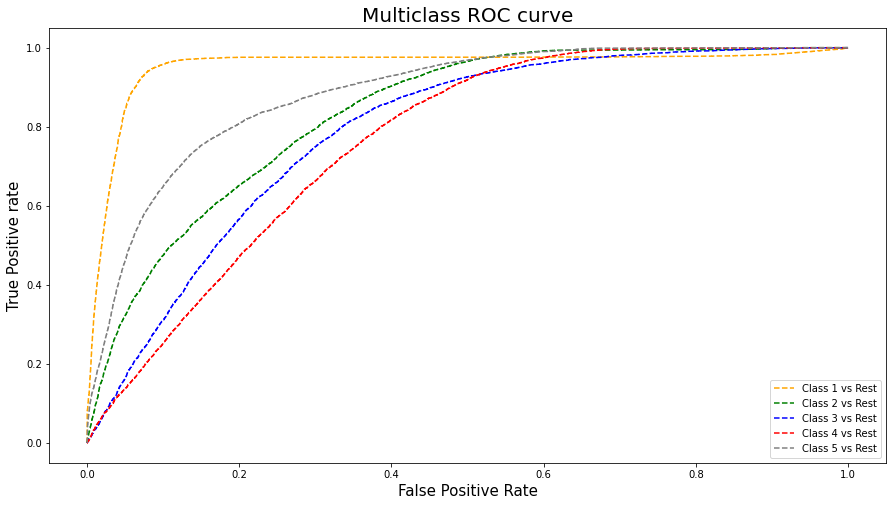

In [ ]:
plot_roc(y_test, y_prob_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for Logistic Regression (OVR)")

##**Model Training**

### Logistic Regression (multinomial)

whereas for the multinomial, the solvers learn a true multinomial logistic regression model, and in this case, the probability estimates should be better calibrated than one-vs-rest. The cross-entropy error/loss function natively support multi-class classification problem. — maximum likelihood estimation

In [ ]:
log_multi = LogisticRegression(multi_class='multinomial', solver='lbfgs')
log_multi.fit(x_train,y_train)

LogisticRegression(multi_class='multinomial')

In [ ]:
# it takes time to run the section
log_multi_results = model_training('Logistic Regression (multinomial)', log_multi, x_train, y_train, 10)
log_multi_results

Algorithm  Accuracy Mean  Accuracy STD  \
0  Logistic Regression (multinomial)           0.59           0.0   

   ROC AUC Mean  ROC AUC STD  Precision Mean  Recall Mean  F1 Mean  
0          0.87          0.0            0.59         0.59     0.59

In [ ]:
acc_log, y_pred, y_prob_pred, report = test_evaluate(log_multi, x_test, y_test)
report


Accuracy: 0.59

Weighted ROC AUC: 0.87
Weighted Precision: 0.58
Weighted Recall: 0.59
Weighted F1-score: 0.59


Class 1      Class 2      Class 3      Class 4      Class 5  \
precision     0.833217     0.581906     0.443198     0.430329     0.615125   
recall        0.875495     0.612312     0.448580     0.304727     0.722260   
f1-score      0.853833     0.596722     0.445873     0.356797     0.664401   
support    6819.000000  6660.000000  6340.000000  7003.000000  7309.000000   

           accuracy     macro avg  weighted avg  
precision  0.594914      0.580755      0.582363  
recall     0.594914      0.592675      0.594914  
f1-score   0.594914      0.583525      0.585334  
support    0.594914  34131.000000  34131.000000

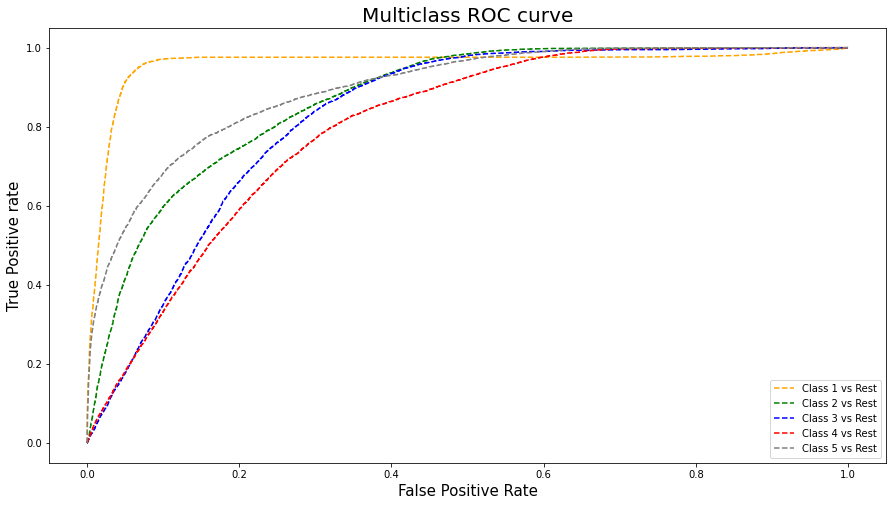

In [ ]:
plot_roc(y_test, y_prob_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for Logistic Regression (multinomial)")

### Logistic Regression (PCA)

Now let's try the better perfomed ovr model with PCA

In [ ]:
log_pca = LogisticRegression(multi_class='multinomial', solver='lbfgs')
log_pca.fit(x_train_pca, y_train)

LogisticRegression(multi_class='multinomial')

In [ ]:
#it takes time to run this section
log_pca_results = model_training('Logistic Regression(PCA)', log_pca, x_train_pca, y_train, 10)
log_pca_results

Algorithm  Accuracy Mean  Accuracy STD  ROC AUC Mean  \
0  Logistic Regression(PCA)           0.48           0.0           0.8   

   ROC AUC STD  Precision Mean  Recall Mean  F1 Mean  
0          0.0            0.48         0.48     0.48

In [ ]:
acc_log_pca, y_pred, y_prob_pred, report = test_evaluate(log_pca, x_test_pca, y_test)
report


Accuracy: 0.49

Weighted ROC AUC: 0.80
Weighted Precision: 0.47
Weighted Recall: 0.49
Weighted F1-score: 0.48


Class 1      Class 2      Class 3      Class 4      Class 5  \
precision     0.684414     0.425590     0.362787     0.343551     0.534931   
recall        0.753517     0.487381     0.267544     0.263513     0.656129   
f1-score      0.717305     0.454394     0.307970     0.298256     0.589364   
support    6824.000000  6736.000000  6384.000000  6975.000000  7212.000000   

           accuracy     macro avg  weighted avg  
precision  0.489379      0.470255      0.471930  
recall     0.489379      0.485617      0.489379  
f1-score   0.489379      0.473458      0.476183  
support    0.489379  34131.000000  34131.000000

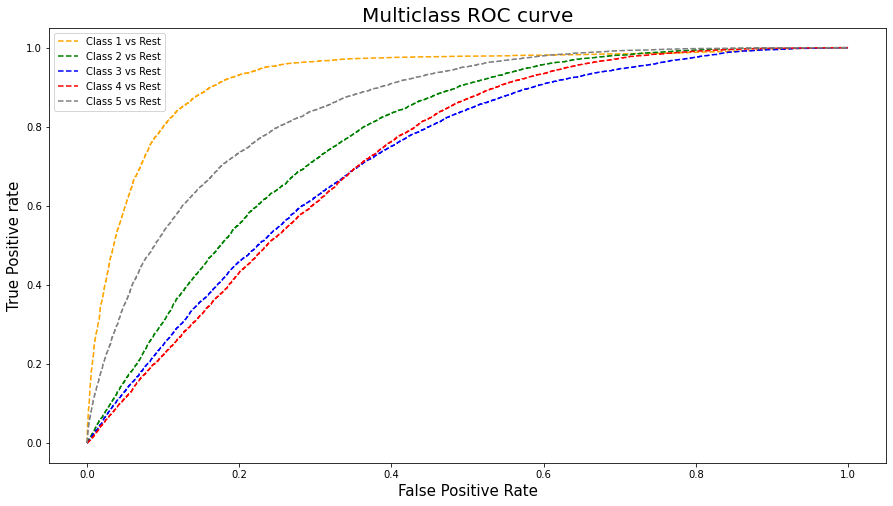

In [ ]:
plot_roc(y_test, y_prob_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for Logistic Regression (multinomial), PCA")

### Gaussian NB 

TheNaive Bayes classifier is suitable for classification with discrete features.

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train,y_train)

GaussianNB()

In [ ]:
# it takes time to run the section
gnb_results = model_training('Gaussian NB', gnb, x_train, y_train, 10)
gnb_results

Algorithm  Accuracy Mean  Accuracy STD  ROC AUC Mean  ROC AUC STD  \
0  Gaussian NB            0.5           0.0          0.82          0.0   

   Precision Mean  Recall Mean  F1 Mean  
0             0.5          0.5      0.5

In [ ]:
acc_gnb, y_pred, y_prob_pred, report = test_evaluate(gnb, x_test, y_test)
report


Accuracy: 0.50

Weighted ROC AUC: 0.83
Weighted Precision: 0.52
Weighted Recall: 0.50
Weighted F1-score: 0.48


Class 1      Class 2      Class 3      Class 4      Class 5  \
precision     0.803446     0.413986     0.418145     0.401869     0.551404   
recall        0.519343     0.693438     0.446898     0.147957     0.691625   
f1-score      0.630886     0.518453     0.432044     0.216284     0.613606   
support    6824.000000  6736.000000  6384.000000  6975.000000  7212.000000   

           accuracy     macro avg  weighted avg  
precision  0.500659      0.517770      0.519191  
recall     0.500659      0.499852      0.500659  
f1-score   0.500659      0.482254      0.483125  
support    0.500659  34131.000000  34131.000000

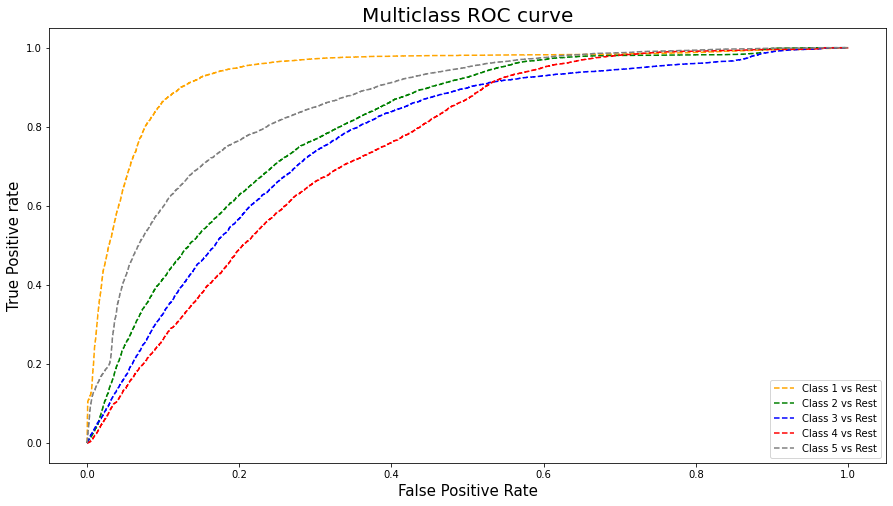

In [ ]:
plot_roc(y_test, y_prob_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for Gaussian NB")

### Gaussian NB (PCA)

In [ ]:
gnb_pca = GaussianNB()
gnb_pca.fit(x_train_pca,y_train)

GaussianNB()

In [ ]:
# it takes time to run the section
gnb_pca_results = model_training('Gaussian NB (PCA)', gnb_pca, x_train_pca, y_train, 10)
gnb_pca_results

Algorithm  Accuracy Mean  Accuracy STD  ROC AUC Mean  ROC AUC STD  \
0  Gaussian NB (PCA)           0.43          0.01          0.77          0.0   

   Precision Mean  Recall Mean  F1 Mean  
0            0.43         0.43     0.43

In [ ]:
acc_gnb_pca, y_pred, y_prob_pred, report = test_evaluate(gnb_pca, x_test_pca, y_test)
report


Accuracy: 0.43

Weighted ROC AUC: 0.78
Weighted Precision: 0.44
Weighted Recall: 0.43
Weighted F1-score: 0.43


Class 1      Class 2      Class 3      Class 4      Class 5  \
precision     0.602460     0.371024     0.344018     0.343561     0.521781   
recall        0.445047     0.571407     0.307644     0.227957     0.606212   
f1-score      0.511926     0.449912     0.324816     0.274067     0.560836   
support    6824.000000  6736.000000  6384.000000  6975.000000  7212.000000   

           accuracy     macro avg  weighted avg  
precision  0.433975      0.436569      0.438488  
recall     0.433975      0.431653      0.433975  
f1-score   0.433975      0.424312      0.426415  
support    0.433975  34131.000000  34131.000000

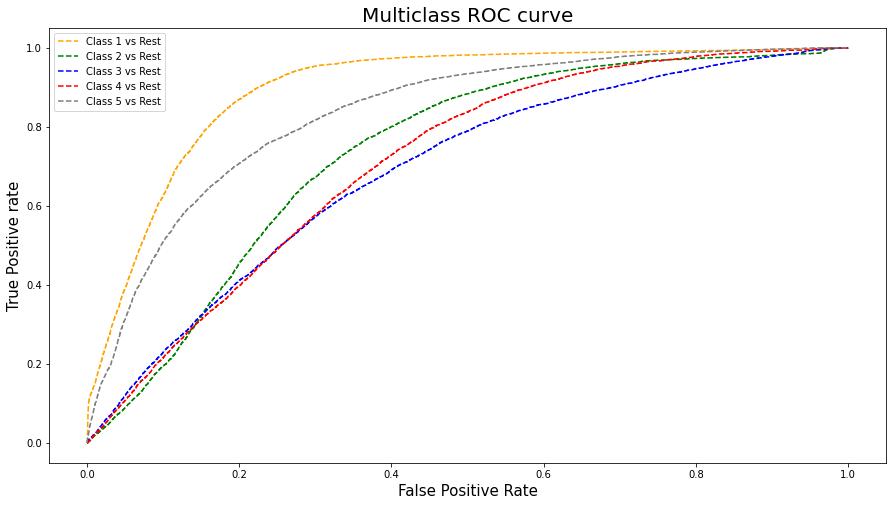

In [ ]:
plot_roc(y_test, y_prob_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for Gaussian NB (PCA)")

### Random Forest

Random forests are ensembles of decision trees: they consist of a bunch of independent decision trees, each of which is trained using only a subset of the features in our training set to ensure that they’re learning to make their predictions in different ways. Their outputs are then pooled together using simple voting.

In [ ]:
rf = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state = 0)
rf.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [ ]:
# it takes time to run the section
rf_results = model_training('Random Forest', rf, x_train, y_train, 10)
rf_results

Algorithm  Accuracy Mean  Accuracy STD  ROC AUC Mean  ROC AUC STD  \
0  Random Forest           0.61           0.0          0.86          0.0   

   Precision Mean  Recall Mean  F1 Mean  
0            0.61         0.61     0.61

In [ ]:
acc_rf, y_pred, y_prob_pred, report = test_evaluate(rf, x_test, y_test)
report


Accuracy: 0.61

Weighted ROC AUC: 0.87
Weighted Precision: 0.61
Weighted Recall: 0.61
Weighted F1-score: 0.61


Class 1      Class 2      Class 3      Class 4      Class 5  \
precision     0.869583     0.605953     0.432379     0.461139     0.677958   
recall        0.952667     0.631681     0.480263     0.432975     0.563367   
f1-score      0.909231     0.618549     0.455065     0.446613     0.615373   
support    6824.000000  6736.000000  6384.000000  6975.000000  7212.000000   

           accuracy     macro avg  weighted avg  
precision  0.612493      0.609402      0.611817  
recall     0.612493      0.612190      0.612493  
f1-score   0.612493      0.608966      0.610280  
support    0.612493  34131.000000  34131.000000

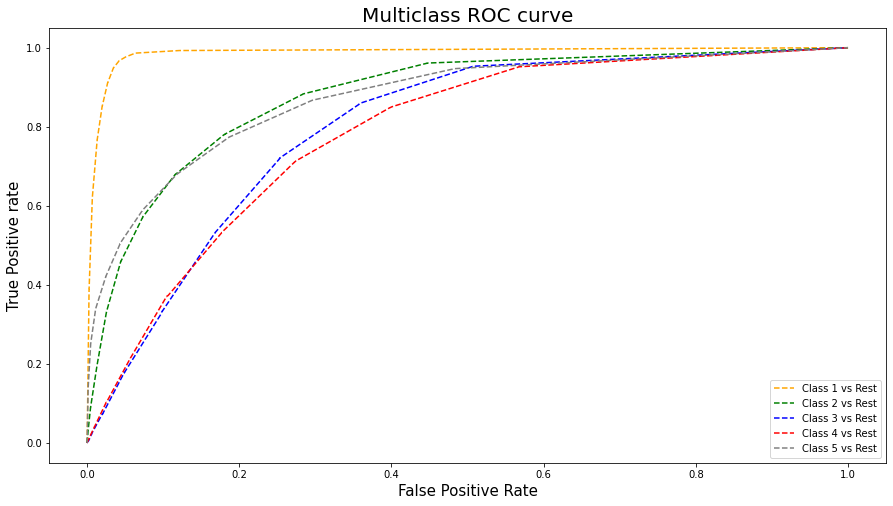

In [ ]:
plot_roc(y_test, y_prob_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for Random Forest(Multi-Class)")

### Random Forest (PCA)

In [ ]:
rf_pca = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state = 0)
rf_pca.fit(x_train_pca, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [ ]:
#this really takes a long time to run
rf_pca_results = model_training('Random Forest (PCA)', rf_pca, x_train_pca, y_train, 10)
rf_pca_results

Algorithm  Accuracy Mean  Accuracy STD  ROC AUC Mean  \
0  Random Forest (PCA)           0.48           0.0          0.78   

   ROC AUC STD  Precision Mean  Recall Mean  F1 Mean  
0          0.0            0.48         0.48     0.48

In [ ]:
acc_rf_pca, y_pred, y_prob_pred, report = test_evaluate(rf_pca, x_test_pca, y_test)
report


Accuracy: 0.47

Weighted ROC AUC: 0.78
Weighted Precision: 0.46
Weighted Recall: 0.47
Weighted F1-score: 0.47


Class 1      Class 2      Class 3      Class 4      Class 5  \
precision     0.682979     0.427180     0.327927     0.340016     0.531841   
recall        0.791471     0.442844     0.319862     0.299068     0.507210   
f1-score      0.733234     0.434871     0.323844     0.318230     0.519233   
support    6824.000000  6736.000000  6384.000000  6975.000000  7212.000000   

           accuracy     macro avg  weighted avg  
precision  0.473763      0.461989      0.464061  
recall     0.473763      0.472091      0.473763  
f1-score   0.473763      0.465883      0.467747  
support    0.473763  34131.000000  34131.000000

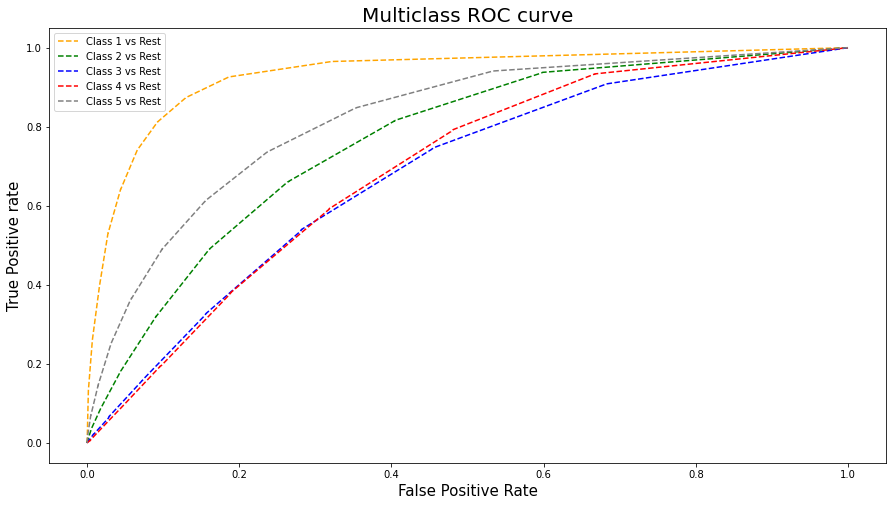

In [ ]:
plot_roc(y_test, y_prob_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for Random Forest(PCA, Multi-Class)")

## Model Comparison

In [ ]:
# concat the model results
frames = [log_ovr_results, log_multi_results, log_pca_results, gnb_results, gnb_pca_results, rf_results, rf_pca_results]

result = pd.concat(frames)

In [ ]:
result

Algorithm  Accuracy Mean  Accuracy STD  \
0          Logistic Regression (OVR)           0.56          0.00   
0  Logistic Regression (multinomial)           0.59          0.00   
0           Logistic Regression(PCA)           0.48          0.00   
0                        Gaussian NB           0.50          0.00   
0                  Gaussian NB (PCA)           0.43          0.01   
0                      Random Forest           0.61          0.00   
0                Random Forest (PCA)           0.48          0.00   

   ROC AUC Mean  ROC AUC STD  Precision Mean  Recall Mean  F1 Mean  
0          0.84          0.0            0.56         0.56     0.56  
0          0.87          0.0            0.59         0.59     0.59  
0          0.80          0.0            0.48         0.48     0.48  
0          0.82          0.0            0.50         0.50     0.50  
0          0.77          0.0            0.43         0.43     0.43  
0          0.86          0.0            0.61         0.61     0.61  
0          0.78          0.0            0.48         0.48     0.48

Accuracy Comparison

In [ ]:
fig = go.Figure(go.Scatter(
    y=result['Accuracy Mean'].values.tolist(),
    x=result.Algorithm.tolist()))

fig.update_layout(
    title={
        'text': "Accuracy Comparison",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show(renderer = 'colab')

AUC ROC Comparison

In [ ]:
fig = go.Figure(go.Scatter(
    y=result['ROC AUC Mean'].values.tolist(),
    x=result.Algorithm.tolist()))

fig.update_layout(
    title={
        'text': "ROC AUC Comparison",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show(renderer = 'colab')

Random Forest seems to be the best model here for multi-class classification, but none of the model accuracy reaches 70%, and all seem to only be able to predict the lowest and highest populartity score better than scores in the middle.

In general, it will not be considered as a good classification model as the prediction is only good for class 1 (least popular songs) and class 5 (most popular songs).

One more thing about PCA, in this classification method, two models accuracy decrease after using PCA transformed data. This might be because:

- PCA is a linear model, but the relationships among features may not have the form of a linear factorization. This implies that PCA will be a distortion.

- PCA can be hard to interpret, because it tends to yield "dense" factorizations, where all features in 𝐴 have nonzero effect on each PC.

- There are potential underfitting problems, but we cannot really add features here.

# **Part 3: Binary Classification**

In [ ]:
# classification: binary class
df_binary = df.dropna()
df_binary = df_binary.drop_duplicates()

## **Response Variable Re-construction**

In this part, we want to try various classification models on this dataset to see if there's a difference on the performace compared with regression models.

Therefore, the first thing we want to do is to convert the continuous numeric variable '*popularity*' into a new response variable with binary classes. We calculate the median of '*popularity*' and set it to be the threshold. Songs with popularity scores greater than or equal to the median will be classified to 1 or Popular; while songs with popularity smaller than the median will be classified as 0 or Not Popular.The newly formed response variable has the data type float, so we then convert that into int type. Since we use Median as the threshold, we avoid the problem of unbalancing data.

We also encode the '*artists*' column into numerical values in order to fit the model. In the last step, we seperate the columns to form the feature matrix X with 15 different features including: valence, year, acousticness, artists, danceability, duration_ms, energy, explicit, instrumentalness, key, liveness, loudness, mode, speechiness and tempo; and a binary response y for popularity.


In [ ]:
df_binary['new_response'] = df_binary['popularity'].copy()
threshold = df_binary['popularity'].median()
for i in range(len(df_binary['new_response'])):
  if df_binary['popularity'][i] >= threshold:
    df_binary['new_response'][i] = 1
  elif df_binary['popularity'][i] < threshold:
    df_binary['new_response'][i] = 0

df_binary = df_binary.astype({'new_response':'int32'})


In [ ]:
artists_list = list(set(df_binary['artists']))
artists_list.sort()
d = dict();
count = 1; 
for art in artists_list:
  d[art] = count;
  count = count+1;
#print('Artists Mapping From String to Number')
#display(d)
df_binary['artists'] = df_binary['artists'].apply(lambda x: d[x])

In [ ]:
x = df_binary.drop(columns = {'id','name','release_date','popularity','new_response'})
y = df_binary['new_response']

In [ ]:
x.dtypes

valence             float64
year                  int64
acousticness        float64
artists               int64
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
dtype: object

### **Train-Test Split**

We then want to split the data set into the training data and testing data. We decided to use 80% of the data to form the train set while the rest 20% to be the test set. 

In [ ]:
from sklearn.model_selection import train_test_split

# TO-DO: Conduct 80/20 train-test split with random_state = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=30)

#### **Model 1: Logistic Regression**

Logistic regression is a process of modeling the probability of a discrete outcome given the input variables using logistic function. It is one of the most commonly used models to deal with binary outcome variable. Therefore, we want to first implement the regular logistic regression model on our data. 


* Accurarcy: 0.695
* ROC_AUC: 0.693
* F1: 0.718

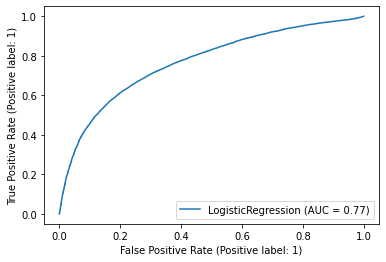

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

log = LogisticRegression()
log.fit(x_train,y_train)
y_pred = log.predict(x_test)

#evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cnf_matrix = confusion_matrix(y_test, y_pred)



#visualize roc/auc
plot_roc_curve(log, x_test, y_test) 
plt.show()

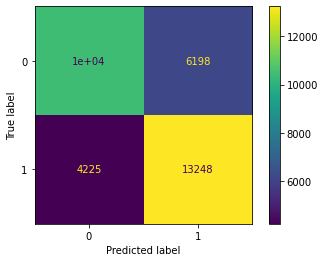

In [ ]:
# visualize confusion matrix of test data
plot_confusion_matrix(log, x_test, y_test) 
plt.show()

In [ ]:
eval_logistic = [accuracy,roc_auc, f1]
eval_logistic

[0.6946177961384079, 0.6930624424901257, 0.7176792437498306]

#### **Model 2: Logistic Regression with Cross-validation**

Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. Since our goal is to predict whether a song is popularity or not, we want to try 10-folds cross validation on our logistic model to see if there's any improvement on the test results. 

* Accurarcy: 0.692
* ROC_AUC: 0.691
* F1: 0.718

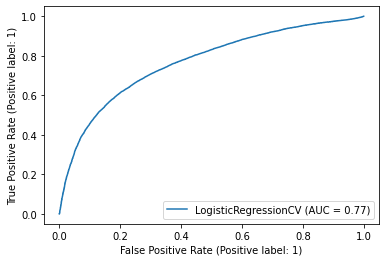

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
logcv = LogisticRegressionCV(cv=10)
logcv.fit(x_train, y_train)
y_pred = logcv.predict(x_test)

#evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cnf_matrix = confusion_matrix(y_test, y_pred)

#visualize roc/auc
plot_roc_curve(logcv, x_test, y_test) 
plt.show()

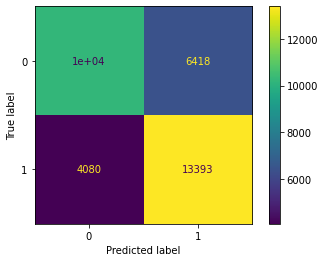

In [ ]:
# visualize confusion matrix of test data
plot_confusion_matrix(logcv, x_test, y_test) 
plt.show()

In [ ]:
eval_logcv = [accuracy,roc_auc, f1]
eval_logcv

[0.6924203802994345, 0.6906082675610787, 0.7184314987662269]

#### **Model 3: Logistic Regression with CV & PCA**

There's no significant improvement after performing the 10-folds cv on logistic regression. We then want to introduce the Principle Component Analysis, since it's commonly used for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible.

We first feed all 15 features to pca and calculate the cumulative variance explained by each pca. We want to choose the number of PCs that could explain about 80% of the variances of data. And by plot the cummulative variance, we choose to use n=9 pcs. We transform our x_train and x_test data matrix based on pca with 9 components and refit the logistic regression model with 10-folds cross validation with the transformed feature matrix. 

* Accurarcy: 0.81
* ROC_AUC: 0.81
* F1: 0.815

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
pca = PCA(n_components=15)
x_train_pca = pca.fit_transform(x_train)

In [ ]:
#refitrefit PCA
pca = PCA(n_components=9)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

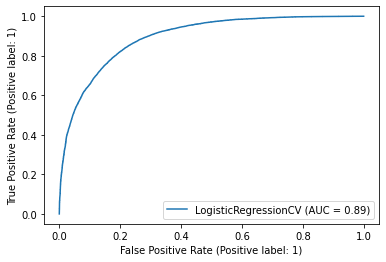

In [ ]:
logcv = LogisticRegressionCV(cv=10)
logcv.fit(x_train_pca,y_train)
y_pred = logcv.predict(x_test_pca)

#evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cnf_matrix = confusion_matrix(y_test, y_pred)

#visualize roc/auc
plot_roc_curve(logcv, x_test_pca, y_test) 
plt.show()

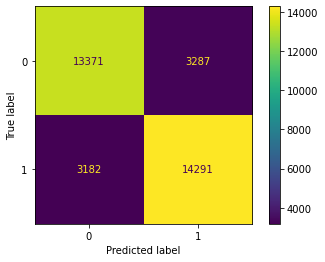

In [ ]:
# visualize confusion matrix of test data
plot_confusion_matrix(logcv,x_test_pca, y_test) 
plt.show()

In [ ]:
eval_logcv_pca = [accuracy,roc_auc, f1]
eval_logcv_pca

[0.8104655591690838, 0.8102839259050774, 0.8154403583349974]

#### **Model 4: Logistic Regression with Lasso Regularization**

In the next step, we try to introduce regularization to the model. Lasso regression are some of the simple techniques to reduce model complexity and prevent over-fitting. Moreover, Lasso tends to do well if there are a small number of significant parameters and the others are close to zero.

* Accurarcy: 0.847
* ROC_AUC: 0.847
* F1: 0.851 

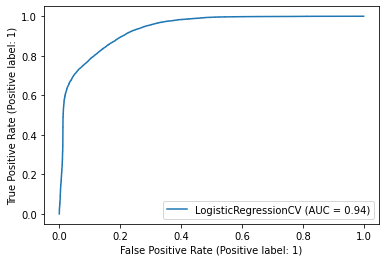

In [ ]:
log_l1 = LogisticRegressionCV(penalty='l1',solver='liblinear',cv=10)
log_l1.fit(x_train,y_train)
y_pred = log_l1.predict(x_test)


#evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cnf_matrix = confusion_matrix(y_test, y_pred)

#visualize roc/auc
plot_roc_curve(log_l1, x_test, y_test) 
plt.show()


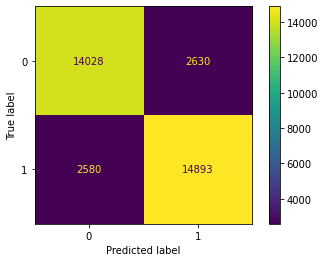

In [ ]:
# visualize confusion matrix of test data
plot_confusion_matrix(log_l1, x_test, y_test) 
plt.show()

In [ ]:
eval_log_l1 = [accuracy,roc_auc, f1]
eval_log_l1

[0.8473528463859834, 0.8472307585865787, 0.8511258429534804]

#### **Model 5: Gaussian Naive Bayes (Gaussian NB)**

Naive Bayes are a group of supervised machine learning classification algorithms based on the Bayes theorem. It is a simple and commonly used classification technique and Gaussian Naive Bayes is a variant of Naive Bayes which assumes that each class in the data follows a Gaussian normal distribution. We try to implement the Gaussian NB model to see if it's a good choice for the binary classification in our case.


* Accurarcy: 0.812
* ROC_AUC: 0.811
* F1: 0.821

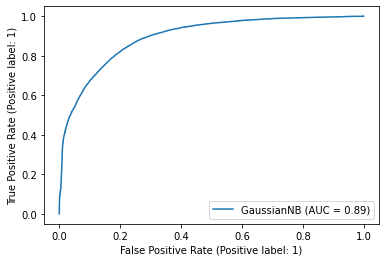

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
#evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
gnb_matrix = confusion_matrix(y_test, y_pred)

#visualize roc/auc
plot_roc_curve(gnb, x_test, y_test) 
plt.show()

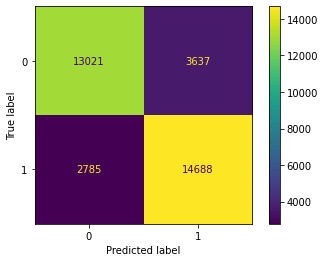

In [ ]:
# visualize confusion matrix of test data
plot_confusion_matrix(gnb, x_test, y_test) 
plt.show()

In [ ]:
eval_gnb = [accuracy,roc_auc, f1]
eval_gnb

[0.8118426064281739, 0.8111388476577727, 0.8206045030448628]

#### **Model 6: Random Forest**
Random Forest is a classifier that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset. Instead of relying on one decision tree, the random forest takes the prediction from each tree and based on the majority votes of predictions, and it predicts the final output. Therefore, random forest classification almost always gives higher accuracy and prevents the overfitting problem.

* Accurarcy: 0.843
* ROC_AUC: 0.841
* F1: 0.857

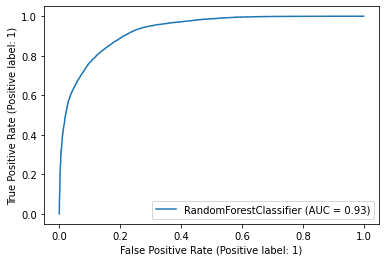

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=4, random_state=0)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)

#evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cnf_matrix = confusion_matrix(y_test, y_pred)

#visualize roc/auc
plot_roc_curve(rf, x_test, y_test) 
plt.show()

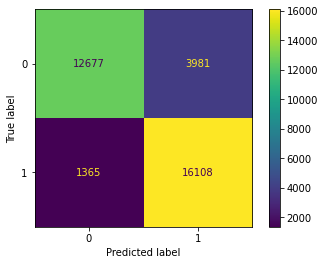

In [ ]:
# visualize confusion matrix of test data
plot_confusion_matrix(rf, x_test, y_test) 
plt.show()

In [ ]:
eval_rf = [accuracy,roc_auc, f1]
eval_rf

[0.8433681989979783, 0.8414475996813828, 0.8576753101538789]

### **Model Comparison for the classification probelm** 

We use Test accuracy, ROC_ACU and F1 score to measure the performance of the six models we implemented. Accuracy measures overall how well the predictions were maken by the model while F1 score is calculated based on the recall and precision of the model.
The first big increase in Accuracy is the Logistic regression with pca. From the correlation plot in EDA, we can see that there's some correlation between columns. Therefore the improvement is reasonable since the PCA can reduce the dimensionality of correlated data and improve the accuracy of classification model. 

We can also see from the evaluation table that logistic regression with L1 penalty(Lasso) also improves the performance of prediction. Random Forest also output an accuracy similar with the logistic lasso, but it has better performance on identifing the true positive values. This gives an intuition that if we values the true positives more when making prediction, we may want to apply the random forest model. In our case, this is somehow true because we want to be able to identify the popular songs correctly since our goal is to learn the possible features that contribute to a good song.

In all, by conducting the classification analysis, we are able to achieve an accuracy of around 0.85 to identify a popular song. This accuracy may be further improved if we could find more possible features related to popularity - for example, the genre of the song. 

In [ ]:
criterion ={ 'Criterion':['Accuracy','ROC/AUC','F1 Score'],'Logistic':eval_logistic,'Logistic with CV':eval_logcv,'Logistic with pca':eval_logcv_pca,'Guassian NB':eval_gnb,'Logistic with Lasso':eval_log_l1,'Random Forest':eval_rf}
comp = pd.DataFrame.from_dict(criterion)
comp

Criterion  Logistic  Logistic with CV  Logistic with pca  Guassian NB  \
0  Accuracy  0.694618          0.692420           0.810466     0.811843   
1   ROC/AUC  0.693062          0.690608           0.810284     0.811139   
2  F1 Score  0.717679          0.718431           0.815440     0.820605   

   Logistic with Lasso  Random Forest  
0             0.847353       0.843368  
1             0.847231       0.841448  
2             0.851126       0.857675

#**Summary**

In this project, we predict popularity score of music from 1921 to 2020 using three methods (regression, multi-class classification and binary classification).
For each method, we use different models and metrcis to compare the results.

In the part of regression, all the variables can explain 45.50% of the variance of target label--popularity, which is kind of weak accountability. Thus, we would like to further leverage classification method to improve the prediction accuracy.

For multi-class classification, the models perform ok but the predictability is only more accurate when it comes to extreme cases such as most popular and least popular. Also, PCA is not working for models here. The general predictability is roughly 60%, which is not entirely satisfactory.

Binary classification in general reports back more accurate results. One possible reason may be that the binary classes are more evenly distributed compared with the multiclasses. In our case, Random forest gives better results for binary classification compared with the multiclass classification. Because we would like to try out different methods, the model tuning part isn't really satisfying. To better tune our models, we can use grid search to find the best parameters for each model. We played with it for each of the model, but the improvement is very limited, and due to the lenghth of the notebook, we decide to only keep the original models. Also, in order to further improve our model,  we could try to find more possible features that are related to popularity - for example, the genre of the song and include those into our model. 

